# Hackeando la Red (Neuronal)

En este notebook voy a demostrar como se pueden modificar una imagen para que una red neuronal la clasifique erróneamente. Y no solo eso, sino para que clasifique una imagen dentro de una categoría que podemos controlar a voluntad. Primero cargamos algunas de las librerías que necesitaremos a lo largo del notebook

In [1]:
import keras
import keras.backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Vamos a cargar dos imágenes llamadas **elefante.bmp** y **elefante_.bmp**. Para ello debemos cargar la imagen mediante el módulo **image** de Keras y lo mostraremos con matplotlib. Las imágenes las cargamos con un tamaño de 299x299 porque es la entrada que espera la red neuronal que usaremos más tarde.

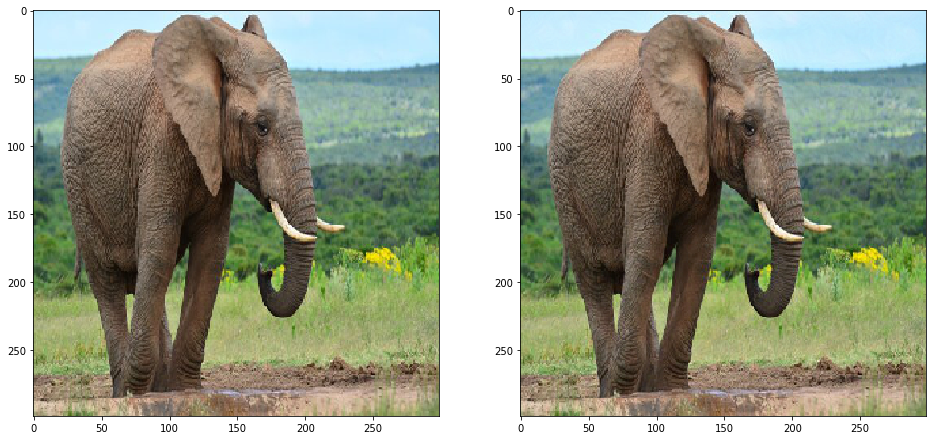

In [2]:
elefante = "elefante.bmp"
elefante_ = "elefante_.bmp"
img_elefante = image.load_img(elefante, target_size=(299, 299))
img_elefante_ = image.load_img(elefante_, target_size=(299, 299))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.imshow(img_elefante)
ax2.imshow(img_elefante_)

Como se puede apreciar, ambas imágenes son parecen idénticas a simple vista. Ahora vamos a cargar la arquitectura **InceptionV3** (más info aquí: https://keras.io/applications/#inceptionv3 y https://arxiv.org/abs/1512.00567) y vamos a decirle que use los parámetros preentrenados para **ImageNet**. ImageNet es una base de datos de imágenes organizadas en 1000 categorías (más info en: http://www.image-net.org/)

In [3]:
model = InceptionV3(weights='imagenet')

Vamos a convertir ahora la imagen **elefante.bmp** en un tensor (generalización del concepto de matriz) de 4 dimensiones. La primera dimensión corresponde al número de imágenes que hemos cargado (en este caso 1) y las siguientes dimensiones corresponden al alto y al ancho de la imagen y al número de canales de la imagen, respectivamente. InceptionV3 espera que el rango de valores del tensor esté entre -1 y +1 (más info en: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py)

**img_elefante** es un tensor de 3 dimensiones (Alto de la imagen, Ancho de la imagen, Número de Canales), es necesario añadirle una cuarta dimensión mediante **np.expand_dims**. Por último se preprocesa la entrada con **preprocess_input** para que los valores de entrada estén entre -1 y +1

In [4]:
arr_elefante = image.img_to_array(img_elefante)
arr_elefante = np.expand_dims(arr_elefante, axis=0)
arr_elefante = preprocess_input(arr_elefante)
print("Dimensiones del tensor", arr_elefante.shape)

preds = model.predict(arr_elefante)
print('Predicciones:', decode_predictions(preds, top=3)[0])

Dimensiones del tensor (1, 299, 299, 3)
Predicciones: [('n02504013', 'Indian_elephant', 0.30272347), ('n01871265', 'tusker', 0.28682062), ('n02504458', 'African_elephant', 0.274948)]


Podemos observar como la red ha clasificado correctamente a la imagen del elefante, diciéndonos que es un elefante indio (Personalmente no me veo cualificado para catalogarlo como elefante indio, pero un elefante si que es). Vamos a probar lo mismo con la otra imagen mostrada.

In [5]:
arr_elefante_ = image.img_to_array(img_elefante_)
arr_elefante_ = np.expand_dims(arr_elefante_, axis=0)
arr_elefante_ = preprocess_input(arr_elefante_)
print("Dimensiones del tensor", arr_elefante.shape)

preds = model.predict(arr_elefante_)
print('Predicciones:', decode_predictions(preds, top=3)[0])

Dimensiones del tensor (1, 299, 299, 3)
Predicciones: [('n03792782', 'mountain_bike', 0.9889936), ('n04509417', 'unicycle', 0.0031806096), ('n02835271', 'bicycle-built-for-two', 0.0006685814)]


En este caso observamos que se ha clasificado como una bicicleta y no como un elefante. ¿Como es posible que esta última imagen haya sido clasificada como una bicicleta si es idéntica a la anterior?

Realmente si analizásemos las imágenes con algún programa de diferencias (epor ejemplo bindiff), veriamos que no son idénticas y que la segunda imagen posee ciertas modificaciones en la intensidad de sus píxeles que hacen que la red neuronal la clasifique como una bicicleta (en concreto como una Mountain Bike).

El método para crear una de estas imágenes modificadas es relativamente sencillo y vamos a intentar explicarlo en las siguientes líneas.

Primero vamos a volver a cargar la imagen del elefante original.

In [6]:
img_elefante = image.load_img(elefante, target_size=(299, 299))
img_elefante = image.img_to_array(img_elefante)
img_elefante = np.expand_dims(img_elefante, axis=0)
img_elefante = preprocess_input(img_elefante)

De lo que se trata es de ir introduciendo pequeños cambios imperceptibles a la imagen original de tal manera que se maximice la propabibilidad de la clase deaseada. En este caso he elegido la clase 671 que corresponde a una Mountain Bike (más info en: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

Para ello debemos obtener la primera y ultima capa de la red neuronal

In [7]:
desired_class = 671
input_layer = model.layers[0].input
output_layer = model.layers[-1].output

A continuación vamos a definir una serie de funciones que nos van a ayudar a conseguir el resultado deseado. Primero obtenemos la probabilidad de que la imagen de entrada sea la clase 671 (Mountain Bike). Después definimos un operador que nos va a ayudar a calcular los gradientes entre la capa de entrada y la probabilidad de la clase Mountain Bike. Por último definimos una función que dada la imagen de entrada (input layer) nos va a devolver los gradientes y la probabilidad. **K.learning_phase** es un flag que se le pasa a la red para que se comporte de distinta forma dependiendo de si se está entrenando la red o si se está testeando (más info en: https://www.tensorflow.org/api_docs/python/tf/keras/backend/learning_phase)

In [8]:
prob = output_layer[0,desired_class]
grads = K.gradients(prob, input_layer)[0]
opt = K.function([input_layer, K.learning_phase()], [grads, prob])

Como queremos aplicar cambios imperceptibles al ojo humano vamos a definir un mínimo y un máximo que se va a poder modificar la imagen, en este caso $\pm 0.01$ (hay que recordar que la imagen se encuentra con valores entre -1 y 1)

In [9]:
img_elefante_copy = np.copy(img_elefante)
limit_sup = img_elefante_copy + 0.01
limit_inf = img_elefante_copy - 0.01

Ahora es cuando empieza lo realmente interesante. Para cada pasada del bucle vamos a calcular los gradientes y la probabilidad de la clase 671. A la imagen original vamos a sumar los gradientes obtenidos y vamos a limitar los valores a los establecidos anteriormente (para que sean imperceptibles), también se limitan los valores a $\pm 1$ ya que es el dominio de los valores de la imágen. En **score** se almacena la probabilidad de, que dada la imagen que le hemos pasado, el resultado sea la categoria Mountain Bike. Este bucle se va a ejecutar hasta que la probabilidad sea superior al 95%.

**Nota:** En este caso el flat **K.learning_phase** se establece a 0. Esto significa que la red se está testeando, esto se hace porque si es 1 (la red está entrenando) se modificarán los pesos de la arquitectura InceptionV3 y no es el comportamiento deseado.

In [10]:
score = 0
while score < 0.95:
    gradients, score = opt([img_elefante_copy, 0])
    img_elefante_copy += gradients
    img_elefante_copy = np.clip(img_elefante_copy,limit_inf, limit_sup)
    img_elefante_copy = np.clip(img_elefante_copy,-1, 1)
    print("probabilidad de que img_elefante sea mountain bike", (score*100))

probabilidad de que img_elefante sea mountain bike 0.0202592636924237
probabilidad de que img_elefante sea mountain bike 0.02030073228524998
probabilidad de que img_elefante sea mountain bike 0.020341917115729302
probabilidad de que img_elefante sea mountain bike 0.02038461243500933
probabilidad de que img_elefante sea mountain bike 0.0204287760425359
probabilidad de que img_elefante sea mountain bike 0.020473942277021706
probabilidad de que img_elefante sea mountain bike 0.020518750534392893
probabilidad de que img_elefante sea mountain bike 0.02056295779766515
probabilidad de que img_elefante sea mountain bike 0.020607329497579485
probabilidad de que img_elefante sea mountain bike 0.020651599334087223
probabilidad de que img_elefante sea mountain bike 0.02069555048365146
probabilidad de que img_elefante sea mountain bike 0.020739168394356966
probabilidad de que img_elefante sea mountain bike 0.02078237448586151
probabilidad de que img_elefante sea mountain bike 0.02082459395751357
pr

probabilidad de que img_elefante sea mountain bike 0.0255932827712968
probabilidad de que img_elefante sea mountain bike 0.0256439670920372
probabilidad de que img_elefante sea mountain bike 0.025694564101286232
probabilidad de que img_elefante sea mountain bike 0.025745489983819425
probabilidad de que img_elefante sea mountain bike 0.025796759291552007
probabilidad de que img_elefante sea mountain bike 0.025848954101093113
probabilidad de que img_elefante sea mountain bike 0.02590151270851493
probabilidad de que img_elefante sea mountain bike 0.025953821022994816
probabilidad de que img_elefante sea mountain bike 0.026006318512372673
probabilidad de que img_elefante sea mountain bike 0.026058455114252865
probabilidad de que img_elefante sea mountain bike 0.026110524777323008
probabilidad de que img_elefante sea mountain bike 0.026162349968217313
probabilidad de que img_elefante sea mountain bike 0.026214029639959335
probabilidad de que img_elefante sea mountain bike 0.0262667104834690

probabilidad de que img_elefante sea mountain bike 0.032305889180861413
probabilidad de que img_elefante sea mountain bike 0.032371500856243074
probabilidad de que img_elefante sea mountain bike 0.0324373395415023
probabilidad de que img_elefante sea mountain bike 0.032503652619197965
probabilidad de que img_elefante sea mountain bike 0.032569721224717796
probabilidad de que img_elefante sea mountain bike 0.032635830575600266
probabilidad de que img_elefante sea mountain bike 0.03270236193202436
probabilidad de que img_elefante sea mountain bike 0.03276909701526165
probabilidad de que img_elefante sea mountain bike 0.03283587284386158
probabilidad de que img_elefante sea mountain bike 0.03290222957730293
probabilidad de que img_elefante sea mountain bike 0.03296871145721525
probabilidad de que img_elefante sea mountain bike 0.03303501580376178
probabilidad de que img_elefante sea mountain bike 0.03310050815343857
probabilidad de que img_elefante sea mountain bike 0.033165872446261346
p

probabilidad de que img_elefante sea mountain bike 0.041198093094863
probabilidad de que img_elefante sea mountain bike 0.041287834756076336
probabilidad de que img_elefante sea mountain bike 0.041378074092790484
probabilidad de que img_elefante sea mountain bike 0.04146792343817651
probabilidad de que img_elefante sea mountain bike 0.04155763308517635
probabilidad de que img_elefante sea mountain bike 0.04164760757703334
probabilidad de que img_elefante sea mountain bike 0.04173782072030008
probabilidad de que img_elefante sea mountain bike 0.04182761185802519
probabilidad de que img_elefante sea mountain bike 0.04191774933133274
probabilidad de que img_elefante sea mountain bike 0.042008195305243134
probabilidad de que img_elefante sea mountain bike 0.042098748963326216
probabilidad de que img_elefante sea mountain bike 0.042189794476144016
probabilidad de que img_elefante sea mountain bike 0.042280860361643136
probabilidad de que img_elefante sea mountain bike 0.04237164102960378
pr

probabilidad de que img_elefante sea mountain bike 0.05353210726752877
probabilidad de que img_elefante sea mountain bike 0.05365779506973922
probabilidad de que img_elefante sea mountain bike 0.053783407201990485
probabilidad de que img_elefante sea mountain bike 0.05390934529714286
probabilidad de que img_elefante sea mountain bike 0.054036680376157165
probabilidad de que img_elefante sea mountain bike 0.054162630112841725
probabilidad de que img_elefante sea mountain bike 0.05428816075436771
probabilidad de que img_elefante sea mountain bike 0.05441347020678222
probabilidad de que img_elefante sea mountain bike 0.05453979829326272
probabilidad de que img_elefante sea mountain bike 0.05466630100272596
probabilidad de que img_elefante sea mountain bike 0.05479311803355813
probabilidad de que img_elefante sea mountain bike 0.054919865215197206
probabilidad de que img_elefante sea mountain bike 0.055045890621840954
probabilidad de que img_elefante sea mountain bike 0.05517121753655374
p

probabilidad de que img_elefante sea mountain bike 0.07034395821392536
probabilidad de que img_elefante sea mountain bike 0.07052436703816056
probabilidad de que img_elefante sea mountain bike 0.07070477586239576
probabilidad de que img_elefante sea mountain bike 0.0708863080944866
probabilidad de que img_elefante sea mountain bike 0.07106838747859001
probabilidad de que img_elefante sea mountain bike 0.07125097909010947
probabilidad de que img_elefante sea mountain bike 0.07143436232581735
probabilidad de que img_elefante sea mountain bike 0.0716192473191768
probabilidad de que img_elefante sea mountain bike 0.0718037597835064
probabilidad de que img_elefante sea mountain bike 0.07198780658654869
probabilidad de que img_elefante sea mountain bike 0.07217209204100072
probabilidad de que img_elefante sea mountain bike 0.07235730299726129
probabilidad de que img_elefante sea mountain bike 0.0725445686839521
probabilidad de que img_elefante sea mountain bike 0.07273219525814056
probabilid

probabilidad de que img_elefante sea mountain bike 0.09554577991366386
probabilidad de que img_elefante sea mountain bike 0.09581002523191273
probabilidad de que img_elefante sea mountain bike 0.09607707615941763
probabilidad de que img_elefante sea mountain bike 0.09634590242058039
probabilidad de que img_elefante sea mountain bike 0.09661506628617644
probabilidad de que img_elefante sea mountain bike 0.096888531697914
probabilidad de que img_elefante sea mountain bike 0.0971620436757803
probabilidad de que img_elefante sea mountain bike 0.09743563132360578
probabilidad de que img_elefante sea mountain bike 0.09771137265488505
probabilidad de que img_elefante sea mountain bike 0.09798572864383459
probabilidad de que img_elefante sea mountain bike 0.09826258756220341
probabilidad de que img_elefante sea mountain bike 0.09854119271039963
probabilidad de que img_elefante sea mountain bike 0.09881890146061778
probabilidad de que img_elefante sea mountain bike 0.09909395594149828
probabili

probabilidad de que img_elefante sea mountain bike 0.1354549778625369
probabilidad de que img_elefante sea mountain bike 0.13589621521532536
probabilidad de que img_elefante sea mountain bike 0.13633366907015443
probabilidad de que img_elefante sea mountain bike 0.1367763732559979
probabilidad de que img_elefante sea mountain bike 0.13722142903134227
probabilidad de que img_elefante sea mountain bike 0.13766518095508218
probabilidad de que img_elefante sea mountain bike 0.13811151729896665
probabilidad de que img_elefante sea mountain bike 0.13855660799890757
probabilidad de que img_elefante sea mountain bike 0.13900278136134148
probabilidad de que img_elefante sea mountain bike 0.13946137623861432
probabilidad de que img_elefante sea mountain bike 0.13991661835461855
probabilidad de que img_elefante sea mountain bike 0.14037799555808306
probabilidad de que img_elefante sea mountain bike 0.14083485584706068
probabilidad de que img_elefante sea mountain bike 0.14129491755738854
probabil

probabilidad de que img_elefante sea mountain bike 0.20798512268811464
probabilidad de que img_elefante sea mountain bike 0.20886496640741825
probabilidad de que img_elefante sea mountain bike 0.20976606756448746
probabilidad de que img_elefante sea mountain bike 0.2106604166328907
probabilidad de que img_elefante sea mountain bike 0.21156067959964275
probabilidad de que img_elefante sea mountain bike 0.21245789248496294
probabilidad de que img_elefante sea mountain bike 0.21334467455744743
probabilidad de que img_elefante sea mountain bike 0.2142314100638032
probabilidad de que img_elefante sea mountain bike 0.21517907734960318
probabilidad de que img_elefante sea mountain bike 0.2161175711080432
probabilidad de que img_elefante sea mountain bike 0.21704926621168852
probabilidad de que img_elefante sea mountain bike 0.21797677036374807
probabilidad de que img_elefante sea mountain bike 0.2189120277762413
probabilidad de que img_elefante sea mountain bike 0.2198446076363325
probabilida

probabilidad de que img_elefante sea mountain bike 0.3878033719956875
probabilidad de que img_elefante sea mountain bike 0.39002925623208284
probabilidad de que img_elefante sea mountain bike 0.39238487370312214
probabilidad de que img_elefante sea mountain bike 0.3945751115679741
probabilidad de que img_elefante sea mountain bike 0.39710430428385735
probabilidad de que img_elefante sea mountain bike 0.3990699537098408
probabilidad de que img_elefante sea mountain bike 0.40164515376091003
probabilidad de que img_elefante sea mountain bike 0.4039924591779709
probabilidad de que img_elefante sea mountain bike 0.4066833294928074
probabilidad de que img_elefante sea mountain bike 0.4091098438948393
probabilidad de que img_elefante sea mountain bike 0.41202125139534473
probabilidad de que img_elefante sea mountain bike 0.41471519507467747
probabilidad de que img_elefante sea mountain bike 0.4172239452600479
probabilidad de que img_elefante sea mountain bike 0.41967155411839485
probabilidad 

probabilidad de que img_elefante sea mountain bike 0.9763659909367561
probabilidad de que img_elefante sea mountain bike 0.9856915101408958
probabilidad de que img_elefante sea mountain bike 0.9977148845791817
probabilidad de que img_elefante sea mountain bike 1.0084106586873531
probabilidad de que img_elefante sea mountain bike 1.0150039568543434
probabilidad de que img_elefante sea mountain bike 1.033735554665327
probabilidad de que img_elefante sea mountain bike 1.0447783395648003
probabilidad de que img_elefante sea mountain bike 1.0552680119872093
probabilidad de que img_elefante sea mountain bike 1.0734882205724716
probabilidad de que img_elefante sea mountain bike 1.068233698606491
probabilidad de que img_elefante sea mountain bike 1.0870694182813168
probabilidad de que img_elefante sea mountain bike 1.1025666259229183
probabilidad de que img_elefante sea mountain bike 1.1321799829602242
probabilidad de que img_elefante sea mountain bike 1.1430846527218819
probabilidad de que im

probabilidad de que img_elefante sea mountain bike 8.129670470952988
probabilidad de que img_elefante sea mountain bike 8.234476298093796
probabilidad de que img_elefante sea mountain bike 7.865508645772934
probabilidad de que img_elefante sea mountain bike 9.065790474414825
probabilidad de que img_elefante sea mountain bike 8.60360935330391
probabilidad de que img_elefante sea mountain bike 9.559320658445358
probabilidad de que img_elefante sea mountain bike 7.872258871793747
probabilidad de que img_elefante sea mountain bike 12.18094602227211
probabilidad de que img_elefante sea mountain bike 12.316828966140747
probabilidad de que img_elefante sea mountain bike 13.23840469121933
probabilidad de que img_elefante sea mountain bike 13.144750893115997
probabilidad de que img_elefante sea mountain bike 15.674479305744171
probabilidad de que img_elefante sea mountain bike 13.395723700523376
probabilidad de que img_elefante sea mountain bike 16.390445828437805
probabilidad de que img_elefan

Por último vamos a revertir los efectos que ha aplicado la función **preprocess_input** (más info en: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py) y vamos a mostrar como ha quedado la imagen que hemos modificado para que la red neuronal nos diga que es una Mountain Bike con una probabilidad superior al 95%

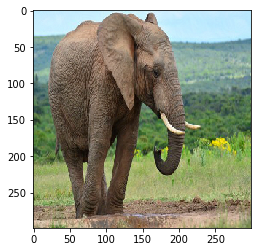

In [11]:
img_elefante_copy += 1
img_elefante_copy *= 127.5
plt.imshow(img_elefante_copy[0].astype(np.uint8))

In [12]:
img_elefante_copy = preprocess_input(img_elefante_copy)

preds = model.predict(img_elefante_copy)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03792782', 'mountain_bike', 0.99105716), ('n04509417', 'unicycle', 0.0029098564), ('n02835271', 'bicycle-built-for-two', 0.001068991)]


# Bonus: Una Mountain Bike de verdad

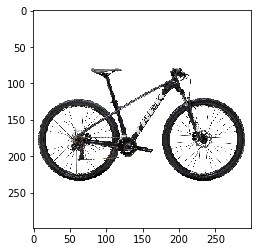

In [13]:
img = image.load_img('bicicleta.jpg', target_size=(299, 299))
plt.imshow(img)

In [14]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

preds = model.predict(img)
print('Predicciones:', decode_predictions(preds, top=3)[0])

Predicciones: [('n03792782', 'mountain_bike', 0.556366), ('n02835271', 'bicycle-built-for-two', 0.0150380675), ('n03785016', 'moped', 0.010217069)]
